In [1]:
%%bash

pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 6.5 MB/s eta 0:00:00


In [36]:
import io
import os
import pathlib
import requests
import tarfile


import bs4
import hyperopt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import sparse, stats
from sklearn import base, feature_extraction, inspection, linear_model, model_selection, pipeline, preprocessing
import shap
import xgboost as xgb


shap.initjs()


In [3]:
DATA_ARCHIVE = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
DATA_DIR = pathlib.Path("./sample_data")

response = requests.get(DATA_ARCHIVE, stream=True)
with tarfile.open(fileobj=response.raw, mode="r|gz") as t:
    t.extractall(DATA_DIR)


In [4]:
def _reviews_to_df(filepath, sentiment):
    d = {"text": [], "sentiment": []}
    review_filepaths = sorted(filepath.glob("*.txt"))
    for review_filepath in review_filepaths:
        with open(review_filepath, 'r') as f:
            review = f.read()
        d["text"].append(review)
        d["sentiment"].append("positive" if sentiment == "pos" else "negative")
    df = pd.DataFrame.from_dict(d)
    return df


def _combine_reviews():
    dfs = []
    for split in ["train", "test"]:
        for sentiment in ["pos", "neg"]:
            df = _reviews_to_df(DATA_DIR / "aclImdb" / split / sentiment, sentiment)
            dfs.append(df)
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df


def partition_reviews(seed=42, test_size=0.2):
    combined_df = _combine_reviews()
    random_state = np.random.RandomState(seed)
    train_df, _val_df = model_selection.train_test_split(
        combined_df,
        random_state=random_state,
        shuffle=True,
        stratify=combined_df["sentiment"],
        test_size=test_size
    )

    # split the _val_df equally into val and test sets
    val_df, test_df = model_selection.train_test_split(
        _val_df,
        random_state=random_state,
        shuffle=True,
        stratify=_val_df["sentiment"],
        test_size=0.5
    )

    return train_df, val_df, test_df


In [5]:
train_df, val_df, test_df = partition_reviews(seed=42)

In [9]:
feature_extraction.text.TfidfVectorizer?

In [11]:
class CustomTfidfVectorizer(base.BaseEstimator, base.TransformerMixin):

    def __init__(self, vectorizer_hyperparams):
        self.vectorizer = (
            feature_extraction.text.TfidfVectorizer(
                **vectorizer_hyperparams
            )
        )

    def fit(self, X, y=None):
        _ = self.vectorizer.fit(X)
        return self

    def transform(self, X):
        Z_csr = self.vectorizer.transform(X)
        Z_arr = Z_csr.toarray()
        Z_df = pd.DataFrame(
            Z_arr,
            columns=self.vectorizer.get_feature_names_out(),
            index=X.index
        )
        return Z_df


class CustomLabelEncoder(base.BaseEstimator, base.TransformerMixin):

    def __init__(self):
        self.encoder = preprocessing.LabelEncoder()

    def fit(self, y):
        _ = self.encoder.fit(y)
        return self

    def transform(self, y):
        z_arr = self.encoder.transform(y)
        z_s = pd.Series(
            z_arr,
            index=y.index,
            name="sentiment"
        )
        return z_s


def strip_html_tags(with_html_tags):
    soup = bs4.BeautifulSoup(with_html_tags)
    without_html_tags = soup.get_text(strip=True)
    return without_html_tags


vectorizer_hyperparams = {
    "lowercase": True,
    "max_df": 0.95, # ignore words that show up in more % of reviews
    "min_df": 0.05, # ignore words than show up in less % of reviews
    "norm": "l2", # normalize rows using
    "dtype": np.float32,
    "stop_words": list(feature_extraction.text.ENGLISH_STOP_WORDS),
}

vectorizer = CustomTfidfVectorizer(
    vectorizer_hyperparams,
)

features_preprocessing = pipeline.make_pipeline(
    preprocessing.FunctionTransformer(
        lambda s: s.apply(strip_html_tags),
    ),
    vectorizer,
)

label_encoder = CustomLabelEncoder()

target_preprocessing = pipeline.make_pipeline(
    label_encoder,
)

In [12]:
X_train = features_preprocessing.fit_transform(train_df.loc[:, "text"])
y_train = target_preprocessing.fit_transform(train_df.loc[:, "sentiment"])

X_val = features_preprocessing.transform(val_df.loc[:, "text"])
y_val = target_preprocessing.transform(val_df.loc[:, "sentiment"])

X_test = features_preprocessing.transform(test_df.loc[:, "text"])
y_test = target_preprocessing.transform(test_df.loc[:, "sentiment"])


The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.


In [61]:
(X_train > 0).mean(axis=0).sort_values().tail(10)

don       0.258750
story     0.296500
really    0.301050
time      0.347450
good      0.378725
just      0.419125
like      0.464600
film      0.555675
movie     0.610400
'         0.889325
dtype: float64

In [37]:
X_train.loc[X_train.loc[:, "don"] > 0.3, "don"].sort_values()

47560    0.300104
33624    0.300207
46035    0.300422
17757    0.300827
47883    0.300929
           ...   
17448    0.611325
26382    0.616422
34969    0.630972
36142    0.646809
8795     0.708206
Name: don, Length: 364, dtype: float32

In [40]:
train_df.loc[8795, "text"]

"OK. There are people who should not see this movie.<br /><br />1) Don't see it if you don't like satire or black humour. 2) Don't like it if you got offended by _The Watchmen_. 3) Don't see it if you want a serious superhero movie.<br /><br />The rest of you, run, don't walk, to see _Mystery Men_. It's funny, it's quirky, it's a delightful sendup of every bad superhero cliche known to man. Occasional forays into junior-high humour don't ruin the tongue-in-cheek low-key fun of Jeanane Garafalo, Ben Stiller, and Hank Azaria, as well as a couple of amusing smaller parts by Geoffrey Rush and Greg Kinnear. (Good to see Louise Lasser getting work, too.) I laughed all the way through. Utterly unserious, somewhat weird, but -good-."

In [42]:
strip_html_tags(train_df.loc[8795, "text"])

"OK. There are people who should not see this movie.1) Don't see it if you don't like satire or black humour. 2) Don't like it if you got offended by _The Watchmen_. 3) Don't see it if you want a serious superhero movie.The rest of you, run, don't walk, to see _Mystery Men_. It's funny, it's quirky, it's a delightful sendup of every bad superhero cliche known to man. Occasional forays into junior-high humour don't ruin the tongue-in-cheek low-key fun of Jeanane Garafalo, Ben Stiller, and Hank Azaria, as well as a couple of amusing smaller parts by Geoffrey Rush and Greg Kinnear. (Good to see Louise Lasser getting work, too.) I laughed all the way through. Utterly unserious, somewhat weird, but -good-."

In [13]:
logistic_regression = linear_model.LogisticRegression()
logistic_regression.fit(X_train, y_train)

print(f"Training accuracy: {logistic_regression.score(X_train, y_train)}")
print(f"Validation accuracy: {logistic_regression.score(X_val, y_val)}")

Training accuracy: 0.813425
Validation accuracy: 0.8084


In [14]:
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [15]:
print(f"Training accuracy: {xgb_classifier.score(X_train, y_train)}")
print(f"Validation accuracy: {xgb_classifier.score(X_val, y_val)}")

Training accuracy: 0.896575
Validation accuracy: 0.8002


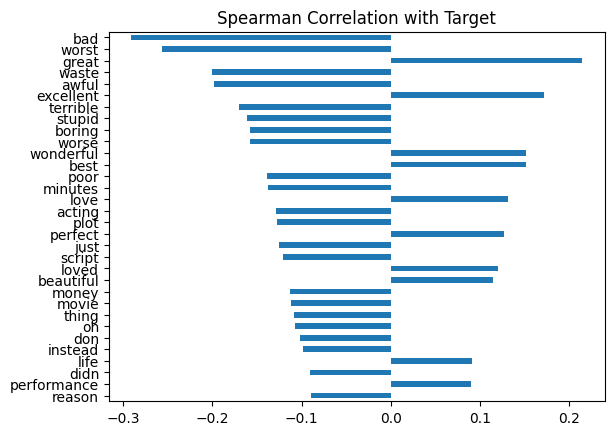

In [35]:
_ = (X_train.assign(target=y_train)
            .corr(method='spearman')
            .drop("target", axis=0)
            .loc[:,"target"]
            .sort_values(key=np.abs)
            .tail(n=32)
            .plot
            .barh(title="Spearman Correlation with Target")
)

In [60]:
(X_train.apply(lambda feature: stats.spearmanr(feature, y_train), axis=0)
        .rename({0: "spearman's r", 1: "p_value"}, axis=0)
        .T
        .query("p_value < 0.01")
        .sort_values(by="spearman's r", key=np.abs, ascending=False))

,spearman's r,p_value
bad,-0.290698,0.000000
worst,-0.256506,0.000000
great,0.214394,0.000000
waste,-0.200127,0.000000
awful,-0.198171,0.000000
...,...,...
getting,-0.018636,0.000193
probably,-0.017986,0.000321
people,-0.017903,0.000343
seeing,0.017529,0.000455


In [61]:
_monotone_constraints = (
    X_train.apply(lambda feature: stats.spearmanr(feature, y_train), axis=0)
           .rename({0: "spearman's r", 1: "p_value"}, axis=0)
           .T
           .query("p_value < 0.01")
           .loc[:, "spearman's r"]
           .apply(lambda r: 1 if r > 0 else -1)
           .to_dict()
)

xgb_classifier = xgb.XGBClassifier(
    monotone_constraints=_monotone_constraints
)
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_thresho...
                                    'beautiful': 1, 'believe': -1, 'best': 1,
                                    'better': -1, 'bit': 1, 'boring': -1,
                                    'budget': -1, 'called': -1, 'camera': -1,
                                    'case': -1, 'cast': 1, 'certainly': 1,
                                    'classic': 1, 'comedy': 1, 'completely': -1,
                                    'couldn': -1, 'couple': -1, 'course': 1,
                                    'day': 1, 'dead': -1, 'definitely': 1,
                                    'dialogue': -1, ...},
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [62]:
print(f"Training accuracy: {xgb_classifier.score(X_train, y_train)}")
print(f"Validation accuracy: {xgb_classifier.score(X_val, y_val)}")

Training accuracy: 0.8416
Validation accuracy: 0.8014


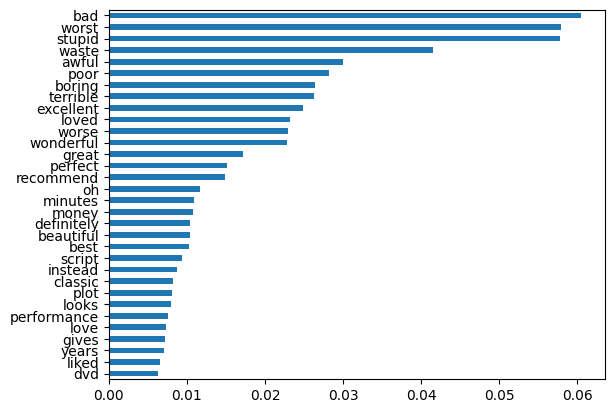

In [58]:
_ = (pd.Series(xgb_classifier.feature_importances_, index=X_train.columns)
 .sort_values()
 .tail(n=32)
 .plot
 .barh()
)

In [ ]:
inspection.PartialDependenceDisplay?

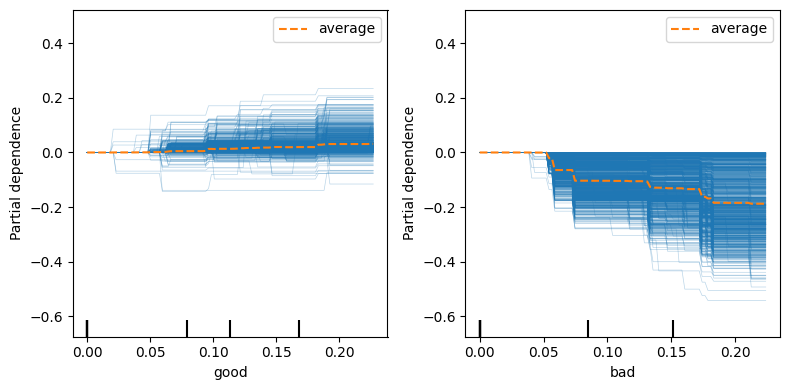

In [23]:
fig, axes = plt.subplots(ncols=2, figsize=(8,4))
_ = (inspection.PartialDependenceDisplay
               .from_estimator(
                  xgb_classifier,
                  X_train,
                  features=["good", "bad"],
                  kind="both",
                  ax=axes,
                  centered=True,)
)
fig.tight_layout()

In [ ]:
shap.plots.partial_dependence?

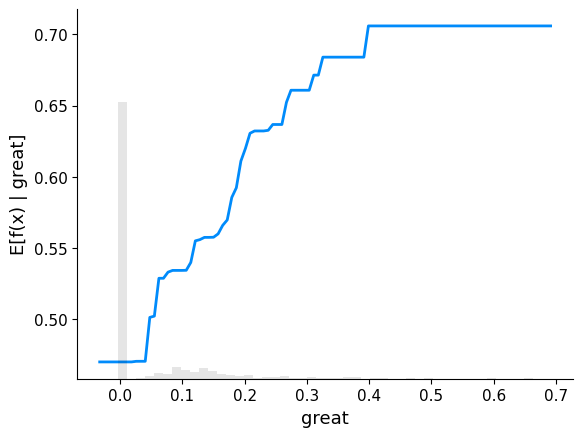

In [24]:
fig, ax = plt.subplots()
_ = (shap.plots
         .partial_dependence(
            ind="great",
            model=lambda row: xgb_classifier.predict_proba(row)[:, -1],
            data=X_train.sample(1000),
            ice=False,
            ax=ax,
            show=False,
            )
)


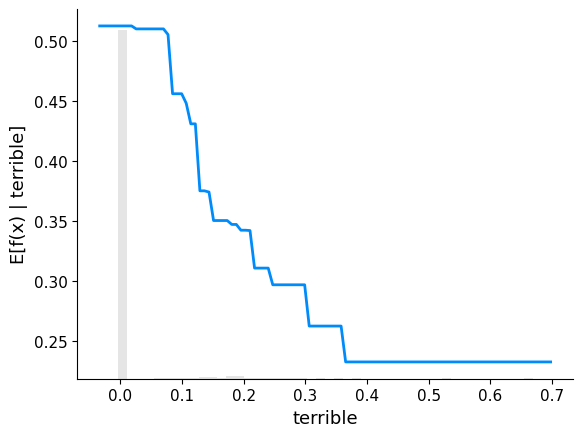

In [25]:
fig, ax = plt.subplots()

_ = (shap.plots
         .partial_dependence(
            ind="terrible",
            model=lambda row: xgb_classifier.predict_proba(row)[:, -1],
            data=X_train.sample(1000),
            ice=False,
            ax=ax,
            show=False,
            )
)

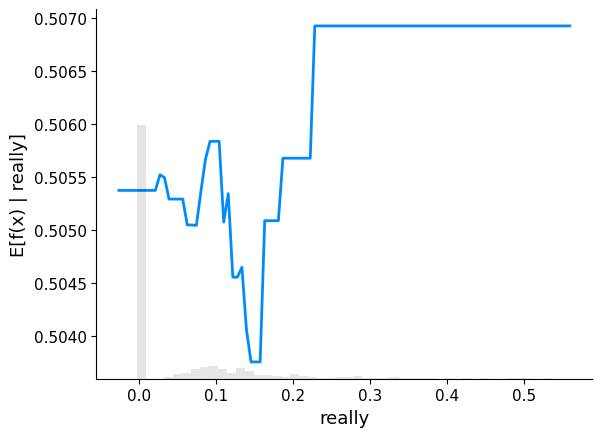

In [26]:
fig, ax = plt.subplots()

_ = (shap.plots
         .partial_dependence(
            ind="really",
            model=lambda row: xgb_classifier.predict_proba(row)[:, -1],
            data=X_train.sample(1000),
            ice=False,
            ax=ax,
            show=False,
            )
)

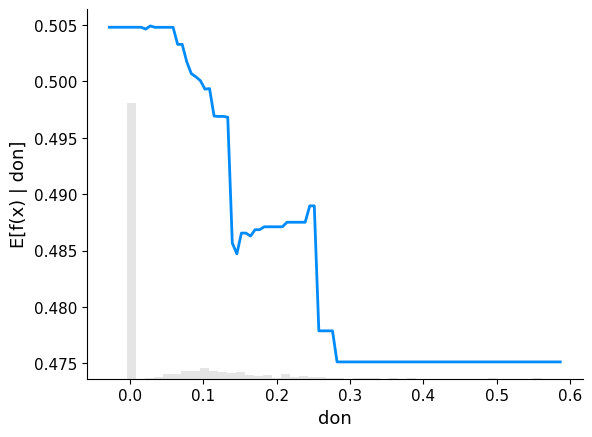

In [27]:
fig, ax = plt.subplots()

_ = (shap.plots
         .partial_dependence(
            ind="don",
            model=lambda row: xgb_classifier.predict_proba(row)[:, -1],
            data=X_train.sample(1000),
            ice=False,
            ax=ax,
            show=False,
            )
)

In [14]:
xgb_classifier = xgb.XGBClassifier(
    monotone_constraints={
        "great": 1,
        "excellent": 1,
        "10": 1,
        "worst": -1,
        "bad": -1,
        "terrible": -1
    }
)
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan,
              monotone_constraints={'10': 1, 'bad': -1, 'excellent': 1,
                                    'great': 1, 'terrible': -1, 'worst': -1},
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [15]:
print(f"Training accuracy: {xgb_classifier.score(X_train, y_train)}")
print(f"Validation accuracy: {xgb_classifier.score(X_val, y_val)}")

Training accuracy: 0.889925
Validation accuracy: 0.8006


In [ ]:
test_df.head(1)

,text,sentiment
15414,This was one of the worst films I have ever se...,negative


In [ ]:
X_test.head(1)

,10,absolutely,acting,action,actor,actors,actually,american,audience,away,...,world,worse,worst,worth,written,wrong,year,years,yes,young
15414,0.152761,0.197542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.173772,0.0,0.0,0.0,0.182742,0.0,0.0,0.0


In [ ]:
test_df.loc[15414, "text"]

'This was one of the worst films I have ever seen.<br /><br />I usually praise any film for some aspect of its production, but the intensely irritating behaviour of more than half the characters made it hard for me to appreciate any part of this film.<br /><br />Most common was the inference that the bloke who designed the building was at fault an avalanche collapsing it. Er ok.<br /><br />Also, trying to out ski an avalanche slalom style is not gonna work. Running 10 feet into some trees is not gonna work. Alas it does here. As mentioned before the innate dumbness and sheer stupidity of some characters is ridiculous. In an enclosed space, with limited oxygen a four year old could tell you starting a fire is not a good idea.<br /><br />Anyway, about 5 minutes of the movie redeems itself and acquires some appreciation. However, if you have a modicum of intelligence you too will find most of this film hard to tolerate.<br /><br />It pains me that so many quality stories go unproduced and

In [ ]:
xgb_classifier.predict(X_test.loc[[15414], :])

array([0])

In [ ]:
tree_explainer.expected_value + explainer_values_df.loc[15414, :].sum()

-4.824167

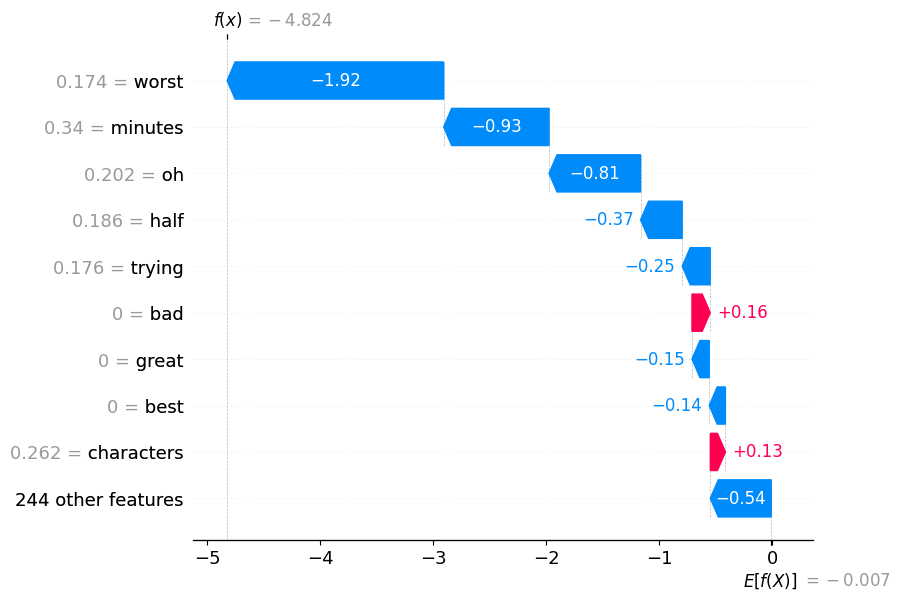

In [ ]:
shap.plots.waterfall(explanation[0])

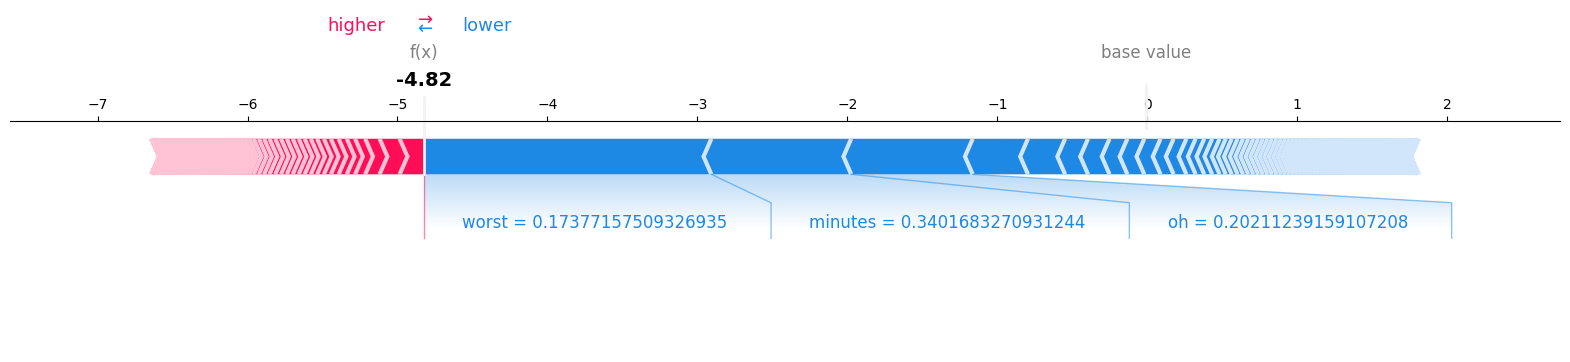

In [ ]:
_ = (
    shap.plots
        .force(
            base_value=explanation.base_values,
            shap_values=explanation.values[0,:],
            features=X_test.iloc[0],
            matplotlib=True,
         )
)

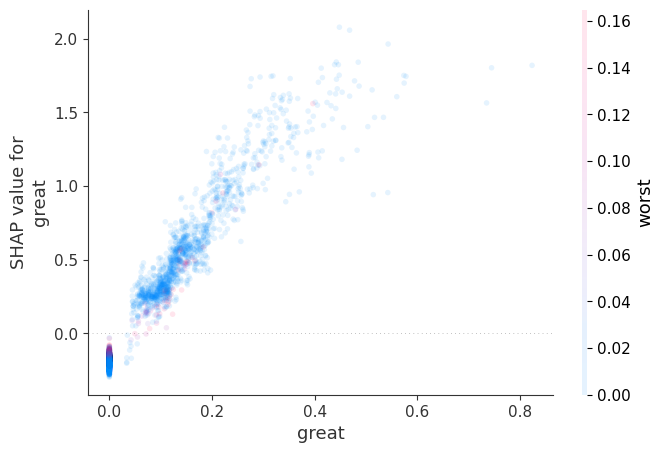

In [ ]:
_ = (
    shap.plots
        .scatter(
            explanation[:, 'great'],
            color=explanation,
            x_jitter=0,
            hist=False,
            alpha=0.1
            )
)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


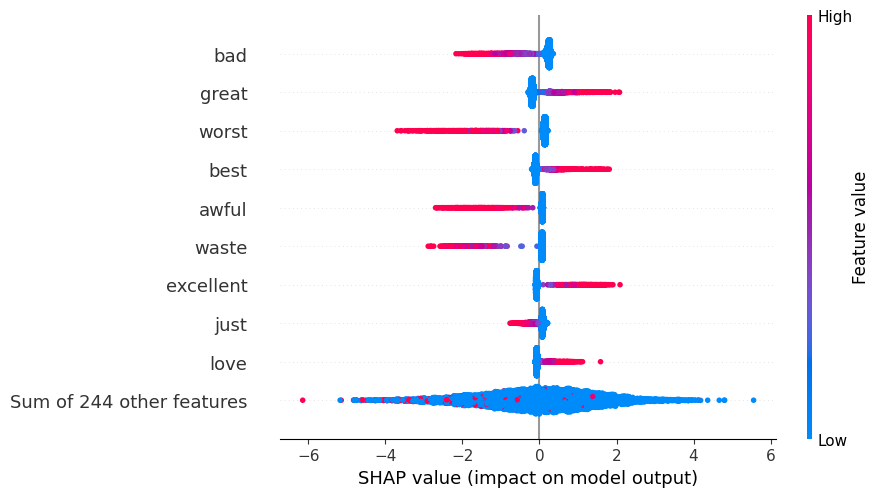

In [ ]:
_ = (
    shap.plots
        .beeswarm(
            explanation,
            )
)